# Selection observed SDSS spectra for validation
I will select SDSS spectra that are within the support of the training data. We'll do this by training a normalizing flow for the training data and then using a logprob threshold to pick SDSS galaxies

In [1]:
import os
import numpy as np 

In [2]:
import torch
from torch import optim
from nflows import transforms, distributions, flows

In [3]:
# --- plotting --- 
import corner as DFM
import matplotlib as mpl
import matplotlib.pyplot as plt
#mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [4]:
seed = 0 
cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda else "cpu")

torch.manual_seed(seed)
if cuda: torch.cuda.manual_seed(seed)

# import observations

In [6]:
dat_dir = '/scratch/network/chhahn/sedflow/'
obs_A_spec = np.load(os.path.join(dat_dir, 'sdss.clean.norm_spec.npy'))
obs_h_spec = np.load(os.path.join(dat_dir, 'sdss.clean.h_spec.npy'))
obs_A_ivar = np.load(os.path.join(dat_dir, 'sdss.clean.norm_ivar.npy'))
obs_h_ivar = np.load(os.path.join(dat_dir, 'sdss.clean.h_ivar.npy'))
obs_zred = np.load(os.path.join(dat_dir, 'sdss.clean.zred.npy'))

In [9]:
obs_data = np.concatenate([obs_A_spec[:,None], obs_h_spec, obs_A_ivar[:,None], obs_h_ivar, obs_zred[:,None]], axis=1)

# import train/test data

In [10]:
test_A_spec = np.load(os.path.join(dat_dir, 'sedflow_p.test.v0.1.norm_spec.npy'))
test_h_spec = np.load(os.path.join(dat_dir, 'sedflow_p.test.v0.1.h_spec.npy'))
test_A_ivar = np.load(os.path.join(dat_dir, 'sedflow_p.test.v0.1.norm_ivar.npy'))
test_h_ivar = np.load(os.path.join(dat_dir, 'sedflow_p.test.v0.1.h_ivar.npy'))
test_zred = np.load(os.path.join(dat_dir, 'sedflow_p.test.v0.1.zred.npy'))

In [11]:
test_data = np.concatenate([test_A_spec[:,None], 
                            test_h_spec, 
                            test_A_ivar[:,None], 
                            test_h_ivar, 
                            test_zred[:,None]], axis=1)

In [14]:
Aspec_clean = test_data[:,0] < 1e3
test_data = test_data[Aspec_clean]

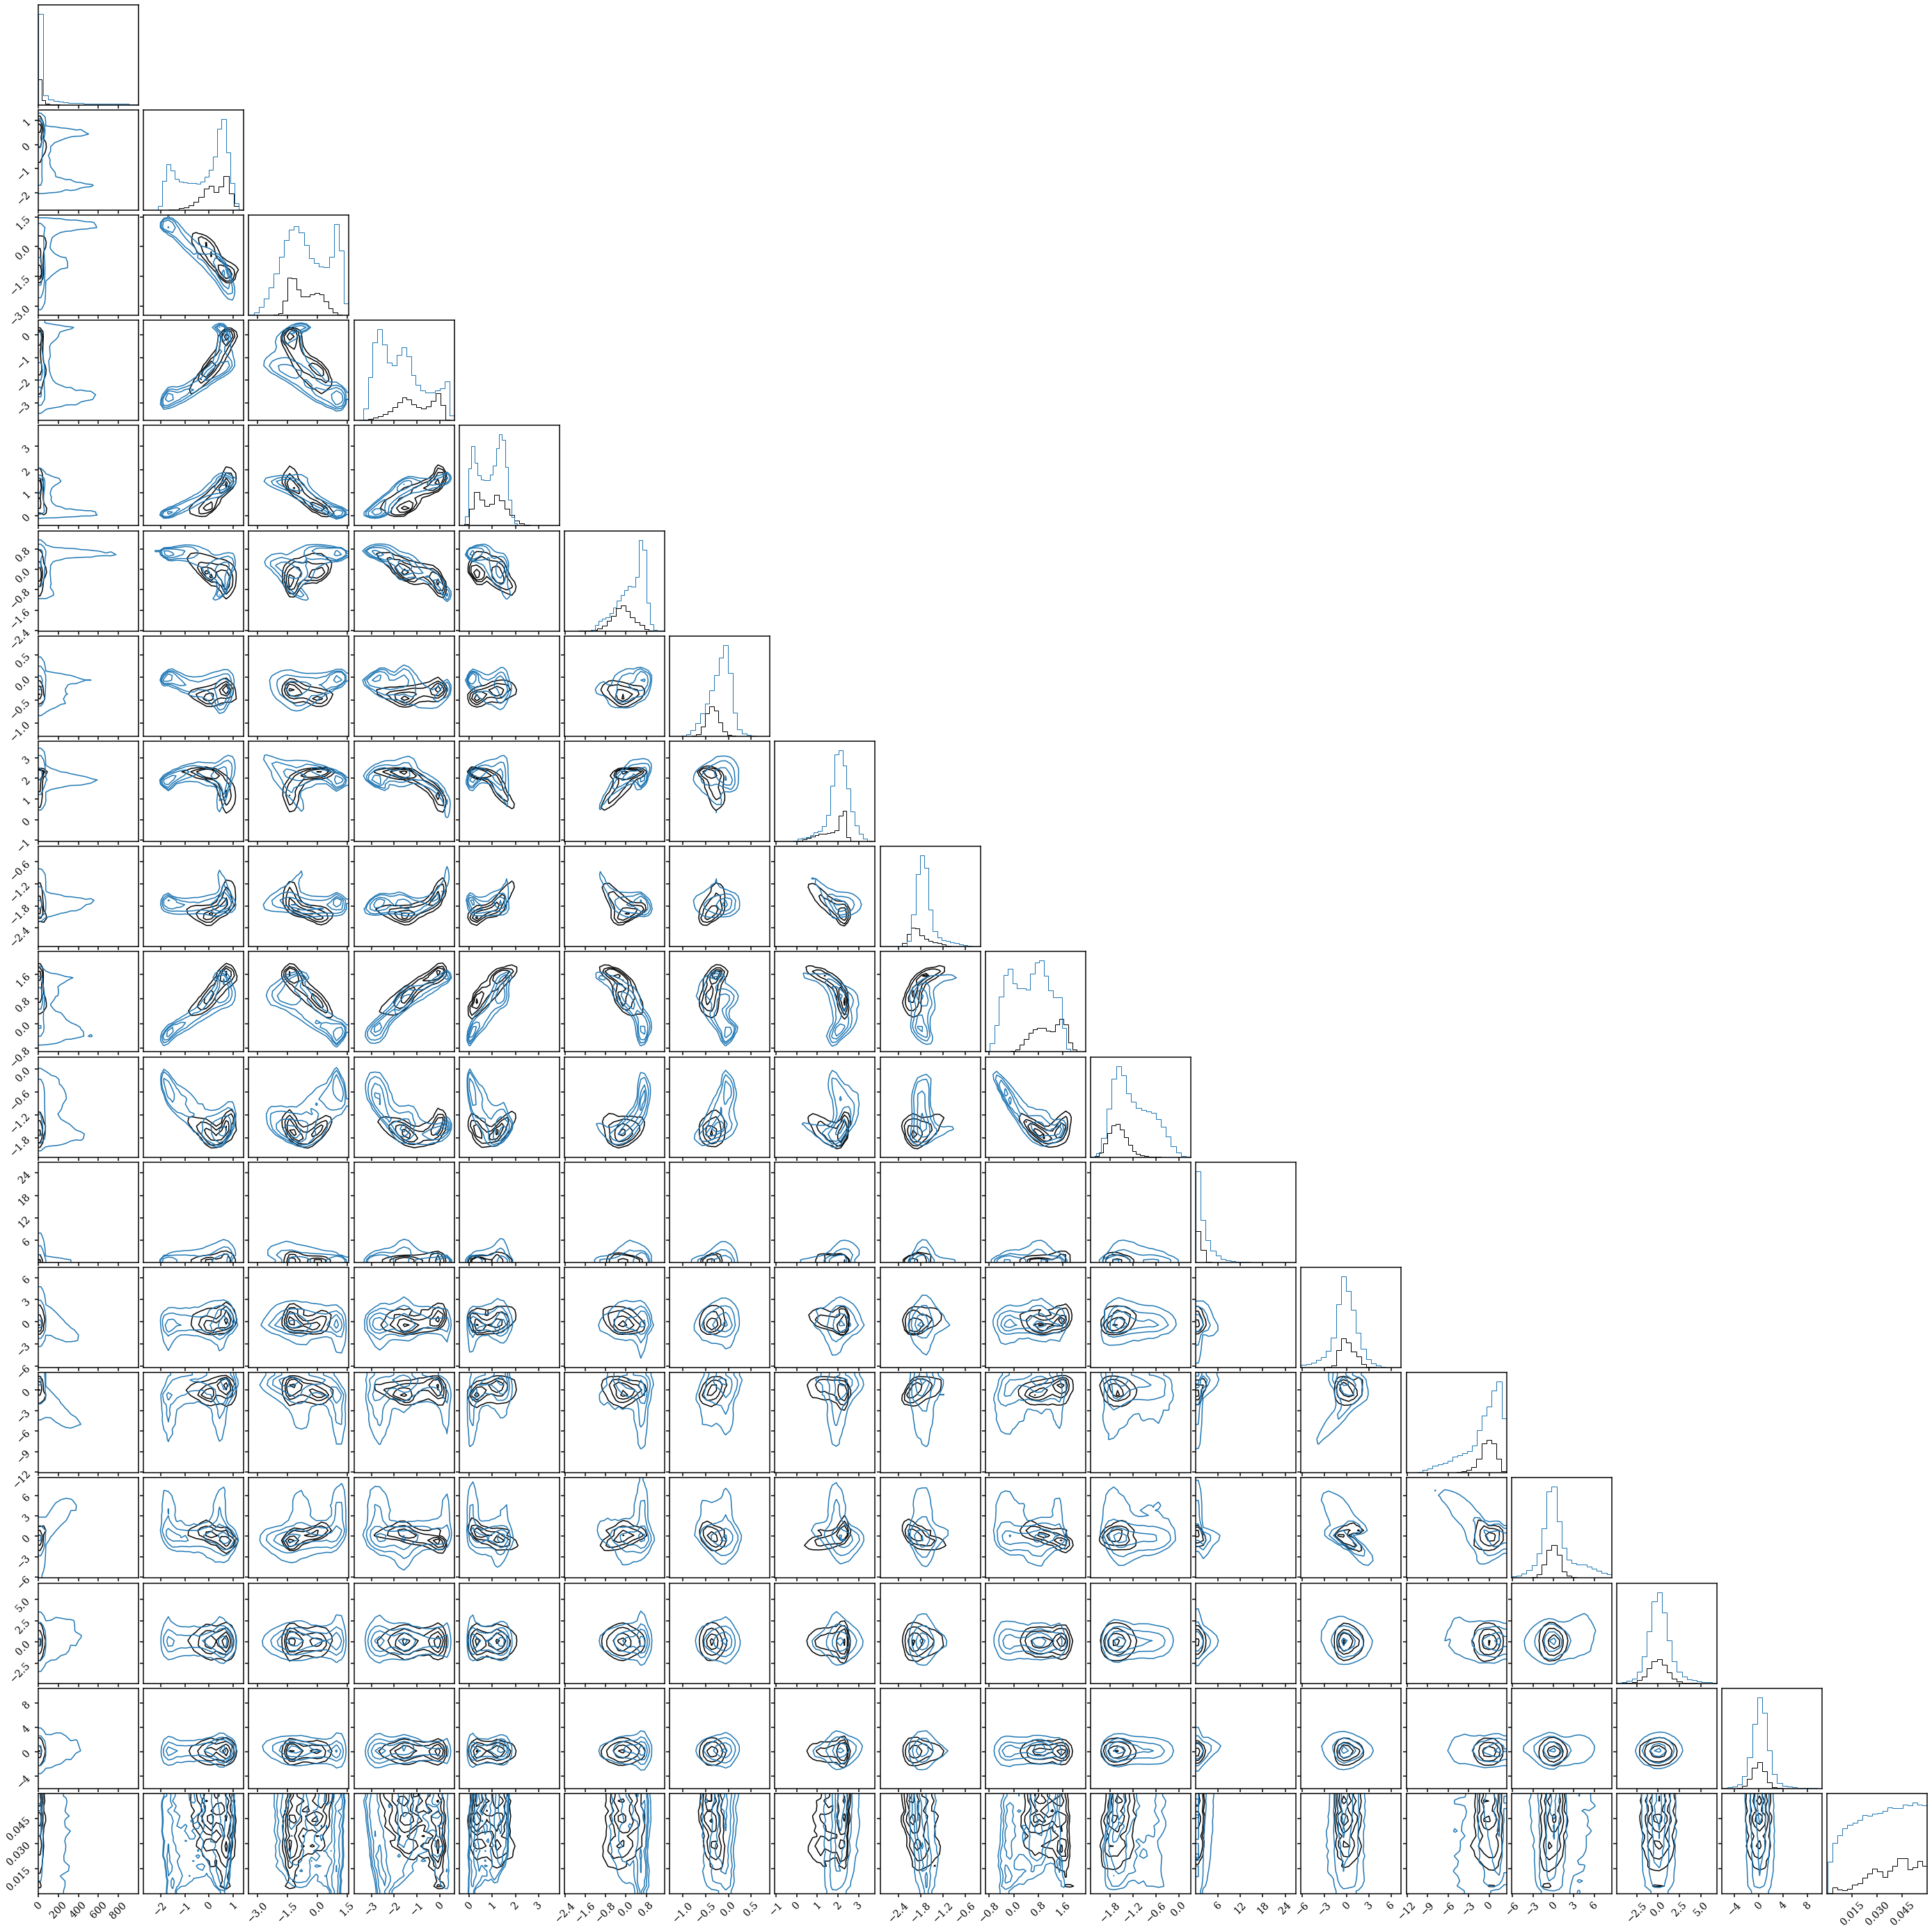

In [15]:
fig = DFM.corner(obs_data, plot_datapoints=False, plot_density=False)
_ = DFM.corner(test_data, plot_datapoints=False, plot_density=False, color='C0', fig=fig)

# train NDE on train/test data

In [16]:
ndim = obs_data.shape[1]
Ntrain = int(0.9 * test_data.shape[0])
train_loader = torch.utils.data.DataLoader(
        torch.tensor(test_data[:Ntrain].astype(np.float32)).to(device), 
        batch_size=512, shuffle=True)
valid_loader = torch.utils.data.DataLoader(
        torch.tensor(test_data[Ntrain:].astype(np.float32)).to(device), 
        batch_size=512, shuffle=False)

In [17]:
all_flows, all_archs, all_valid_losses = [], [], []
for i in range(5): 
    nhidden = int(np.ceil(np.exp(np.random.uniform(np.log(64), np.log(256)))))
    nblocks = int(np.random.uniform(3, 7))
    all_archs.append('%ix%i' % (nhidden, nblocks))

    blocks = []
    for iblock in range(nblocks): 
        blocks += [transforms.MaskedAffineAutoregressiveTransform(features=ndim, hidden_features=nhidden),
                transforms.RandomPermutation(features=ndim)]
    transform = transforms.CompositeTransform(blocks)

    base_distribution = distributions.StandardNormal(shape=[ndim])
    flow = flows.Flow(transform=transform, distribution=base_distribution)
    flow.to(device)

    num_iter = 1000
    patience = 20

    optimizer = optim.Adam(flow.parameters(), lr=1e-3)
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer, 1e-3, total_steps=num_iter)

    best_epoch, best_valid_loss, valid_losses = 0, np.inf, []
    for epoch in range(num_iter):
        train_loss = 0.
        for batch in train_loader: 
            optimizer.zero_grad()
            loss = -flow.log_prob(batch).mean()
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
        train_loss = train_loss/float(len(train_loader))

        with torch.no_grad():
            valid_loss = 0.
            for batch in valid_loader: 
                loss = -flow.log_prob(batch).mean()
                valid_loss += loss.item()
            valid_loss = valid_loss/len(valid_loader)
            valid_losses.append(valid_loss)

            if epoch % 20 == 0: print('%i \t %.2e \t %.2e' % (epoch, train_loss, valid_loss))
            if valid_loss < best_valid_loss: 
                best_valid_loss = valid_loss
                best_epoch = epoch
            else: 
                if best_epoch < epoch - patience: 
                    print('>>>%i \t %.5e' % (epoch, best_valid_loss))
                    break
            scheduler.step()

    all_flows.append(flow)
    all_valid_losses.append(valid_losses)

0 	 1.87e+08 	 1.14e+06
20 	 7.28e+01 	 7.18e+01
40 	 3.65e+01 	 3.62e+01
60 	 2.17e+01 	 2.15e+01
80 	 1.33e+01 	 1.31e+01
100 	 9.32e+00 	 9.20e+00
120 	 7.60e+00 	 7.58e+00
140 	 6.72e+00 	 6.65e+00
160 	 6.03e+00 	 6.01e+00
180 	 5.42e+00 	 5.55e+00
200 	 5.36e+00 	 6.90e+00
220 	 4.46e+00 	 4.52e+00
240 	 4.22e+00 	 4.12e+00
260 	 5.78e+00 	 6.15e+00
280 	 3.86e+00 	 5.13e+00
300 	 3.49e+00 	 3.61e+00
320 	 3.10e+00 	 3.74e+00
340 	 2.82e+00 	 3.28e+00
360 	 2.60e+00 	 2.65e+00
380 	 2.37e+00 	 2.80e+00
>>>393 	 2.39195e+00
0 	 1.48e+21 	 3.08e+20
20 	 1.29e+21 	 2.60e+20
40 	 1.07e+21 	 2.07e+20
60 	 7.79e+20 	 1.29e+20
80 	 4.09e+20 	 4.68e+19
100 	 7.24e+18 	 3.60e+12
120 	 2.71e+10 	 1.34e+10
140 	 1.29e+10 	 1.76e+10
>>>146 	 8.26667e+09
0 	 7.06e+10 	 6.82e+07
20 	 4.94e+03 	 4.69e+03
40 	 2.44e+02 	 3.27e+02
60 	 2.99e+01 	 1.25e+02
80 	 1.92e+01 	 5.22e+02
100 	 1.32e+01 	 1.31e+01
120 	 1.10e+01 	 1.11e+01
140 	 6.28e+01 	 5.91e+01
>>>156 	 9.92092e+00
0 	 3.39e+25 	 3.73

In [18]:
min_vl = np.array([np.min(vl) for vl in all_valid_losses])
min_vl[np.isnan(min_vl)] = np.inf
ibest = np.argmin(min_vl)
best_flow = all_flows[ibest]
best_arch = all_archs[ibest]

In [19]:
with torch.no_grad(): 
    nde_samples = best_flow.sample(10000)

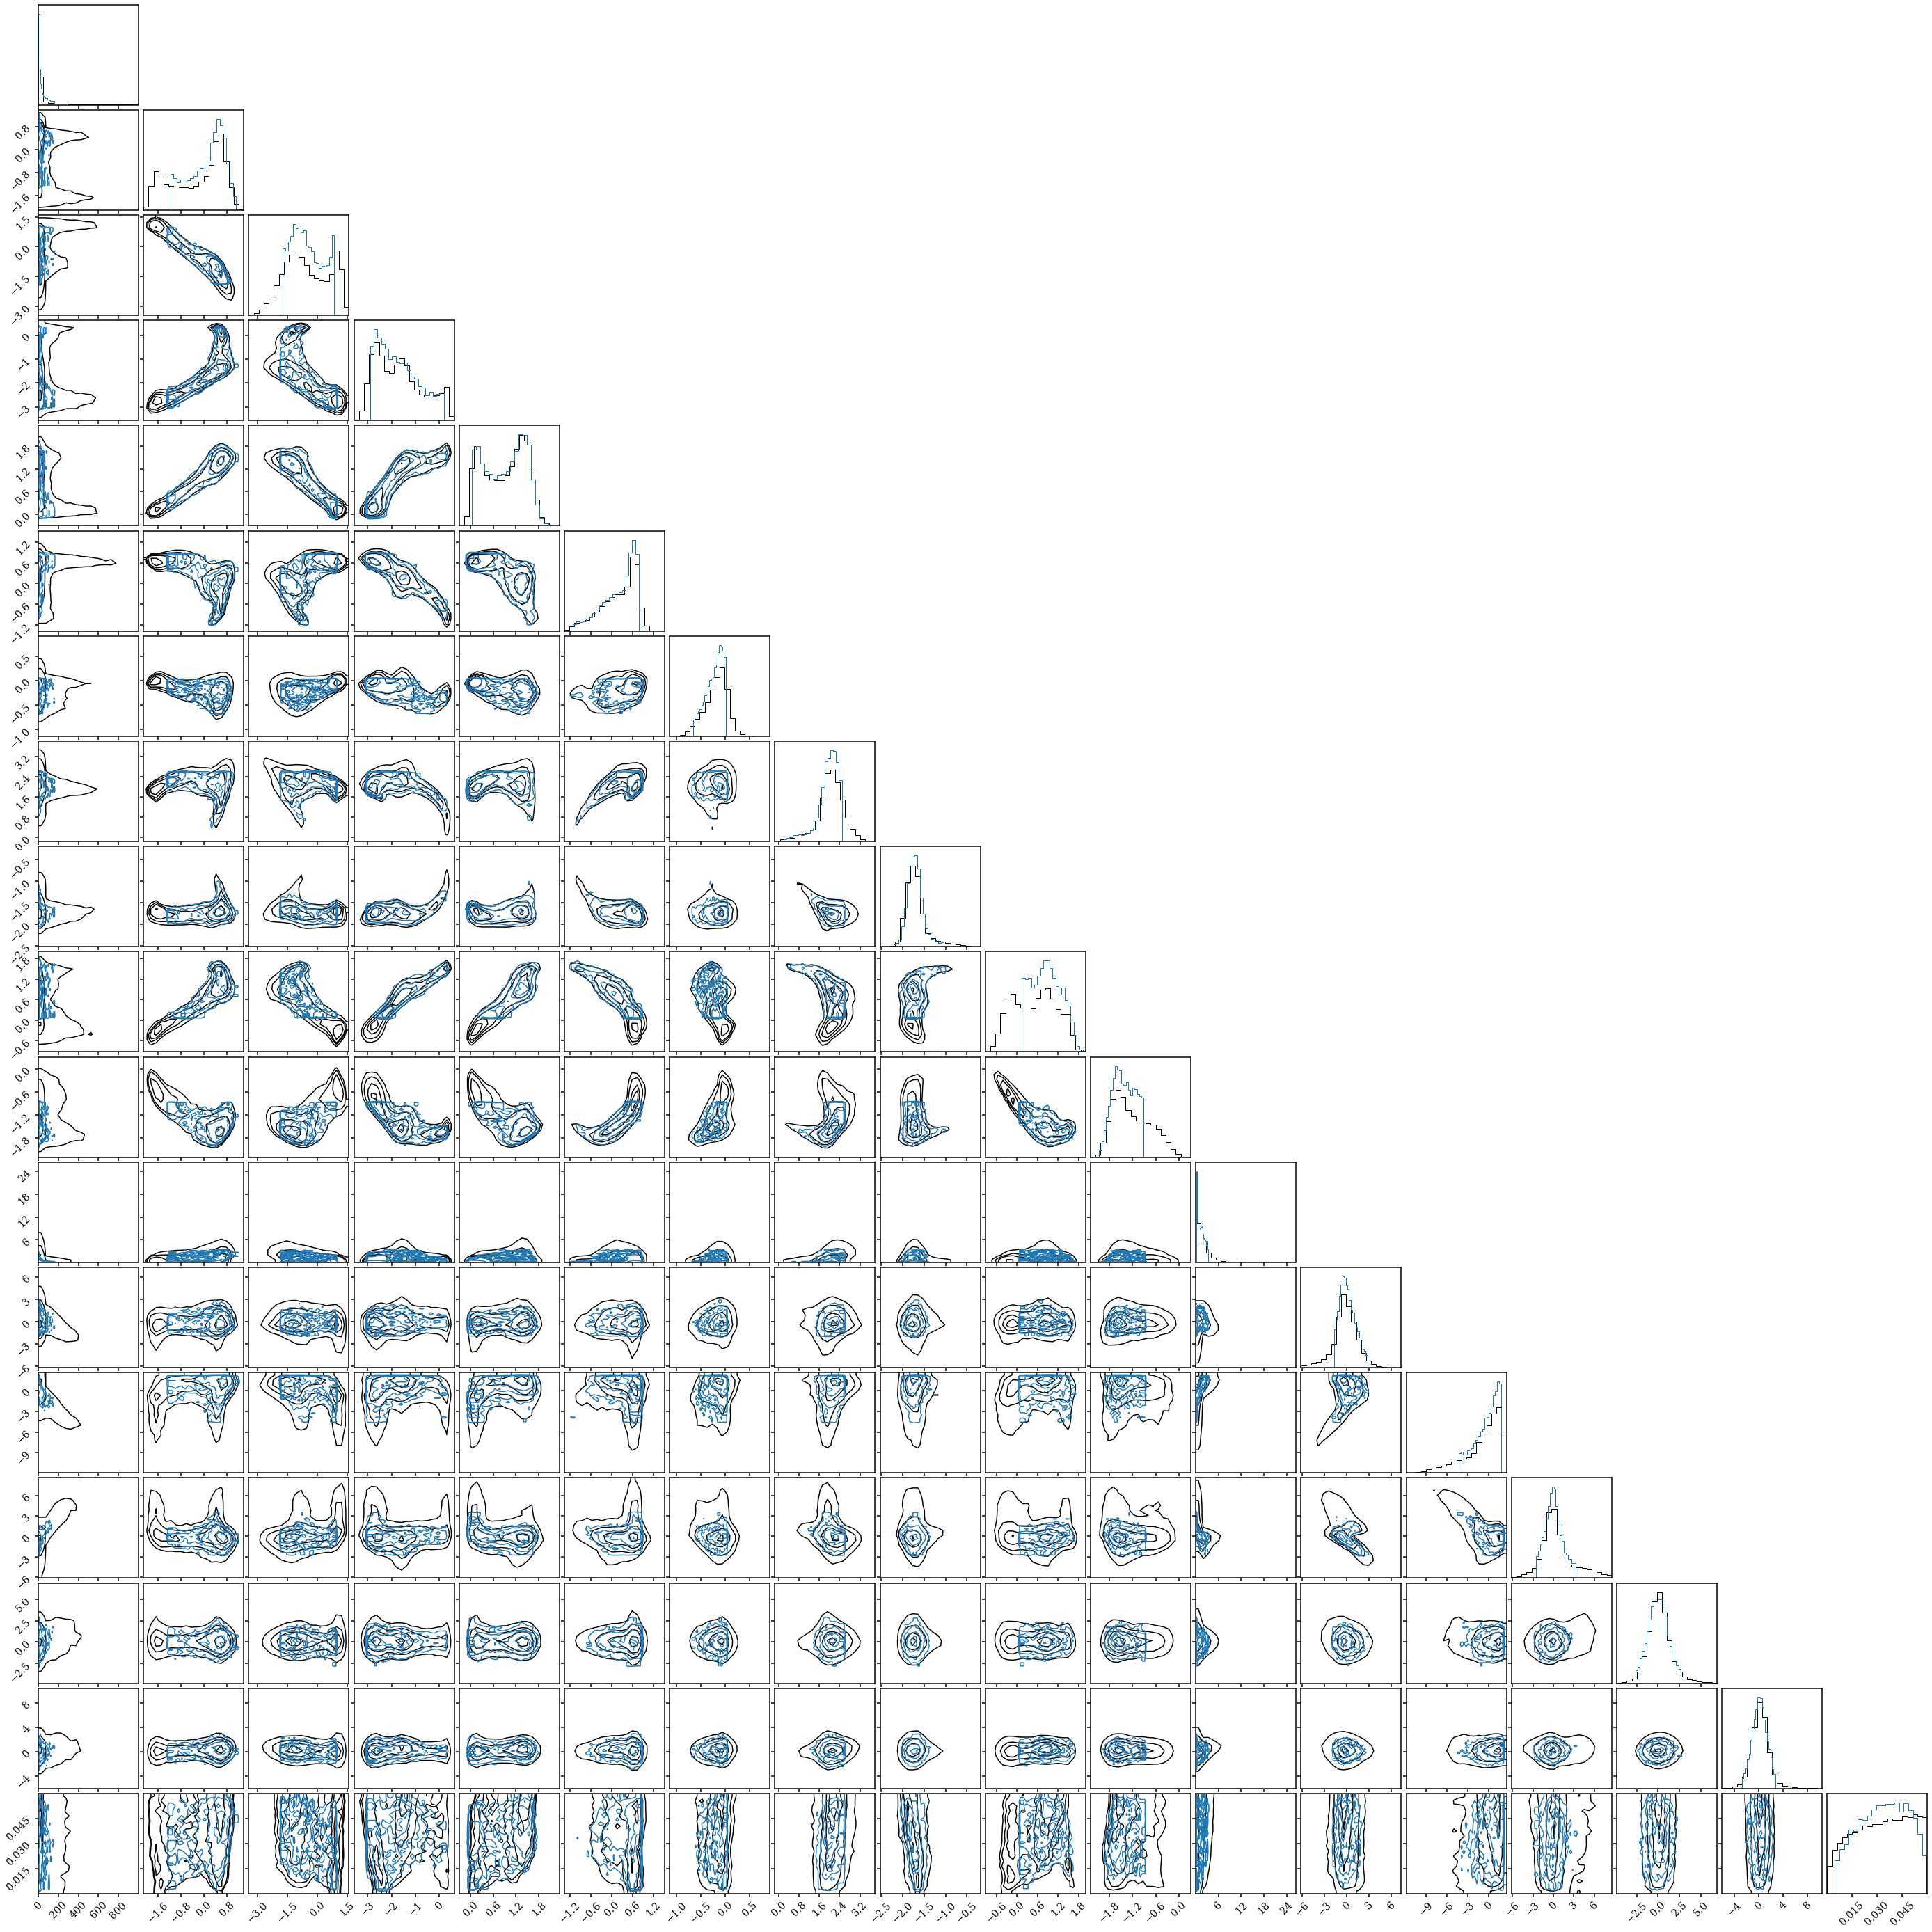

In [20]:
fig = DFM.corner(test_data,
                 hist_kwargs={'density': True},
                 plot_datapoints=False, plot_density=False)
_ = DFM.corner(np.array(nde_samples.detach().cpu()), color='C0', 
               range=[np.nanquantile(obs_col, [0.01, 0.99]) for obs_col in obs_data.T],
               hist_kwargs={'density': True},
               plot_datapoints=False, plot_density=False, fig=fig)

## keep only the observations within train/test data support 

In [21]:
obs_loader = torch.utils.data.DataLoader(
    torch.tensor(obs_data.astype(np.float32)).to(device), 
    batch_size=512, shuffle=False)

with torch.no_grad(): 
    obs_logprob = []
    for batch in obs_loader: 
        logprob = best_flow.log_prob(batch)
        obs_logprob.append(np.array(logprob.detach().cpu()))
obs_logprob = np.concatenate(obs_logprob)

In [24]:
logprob_cut = (obs_logprob > -5)
print(np.sum(logprob_cut))

407


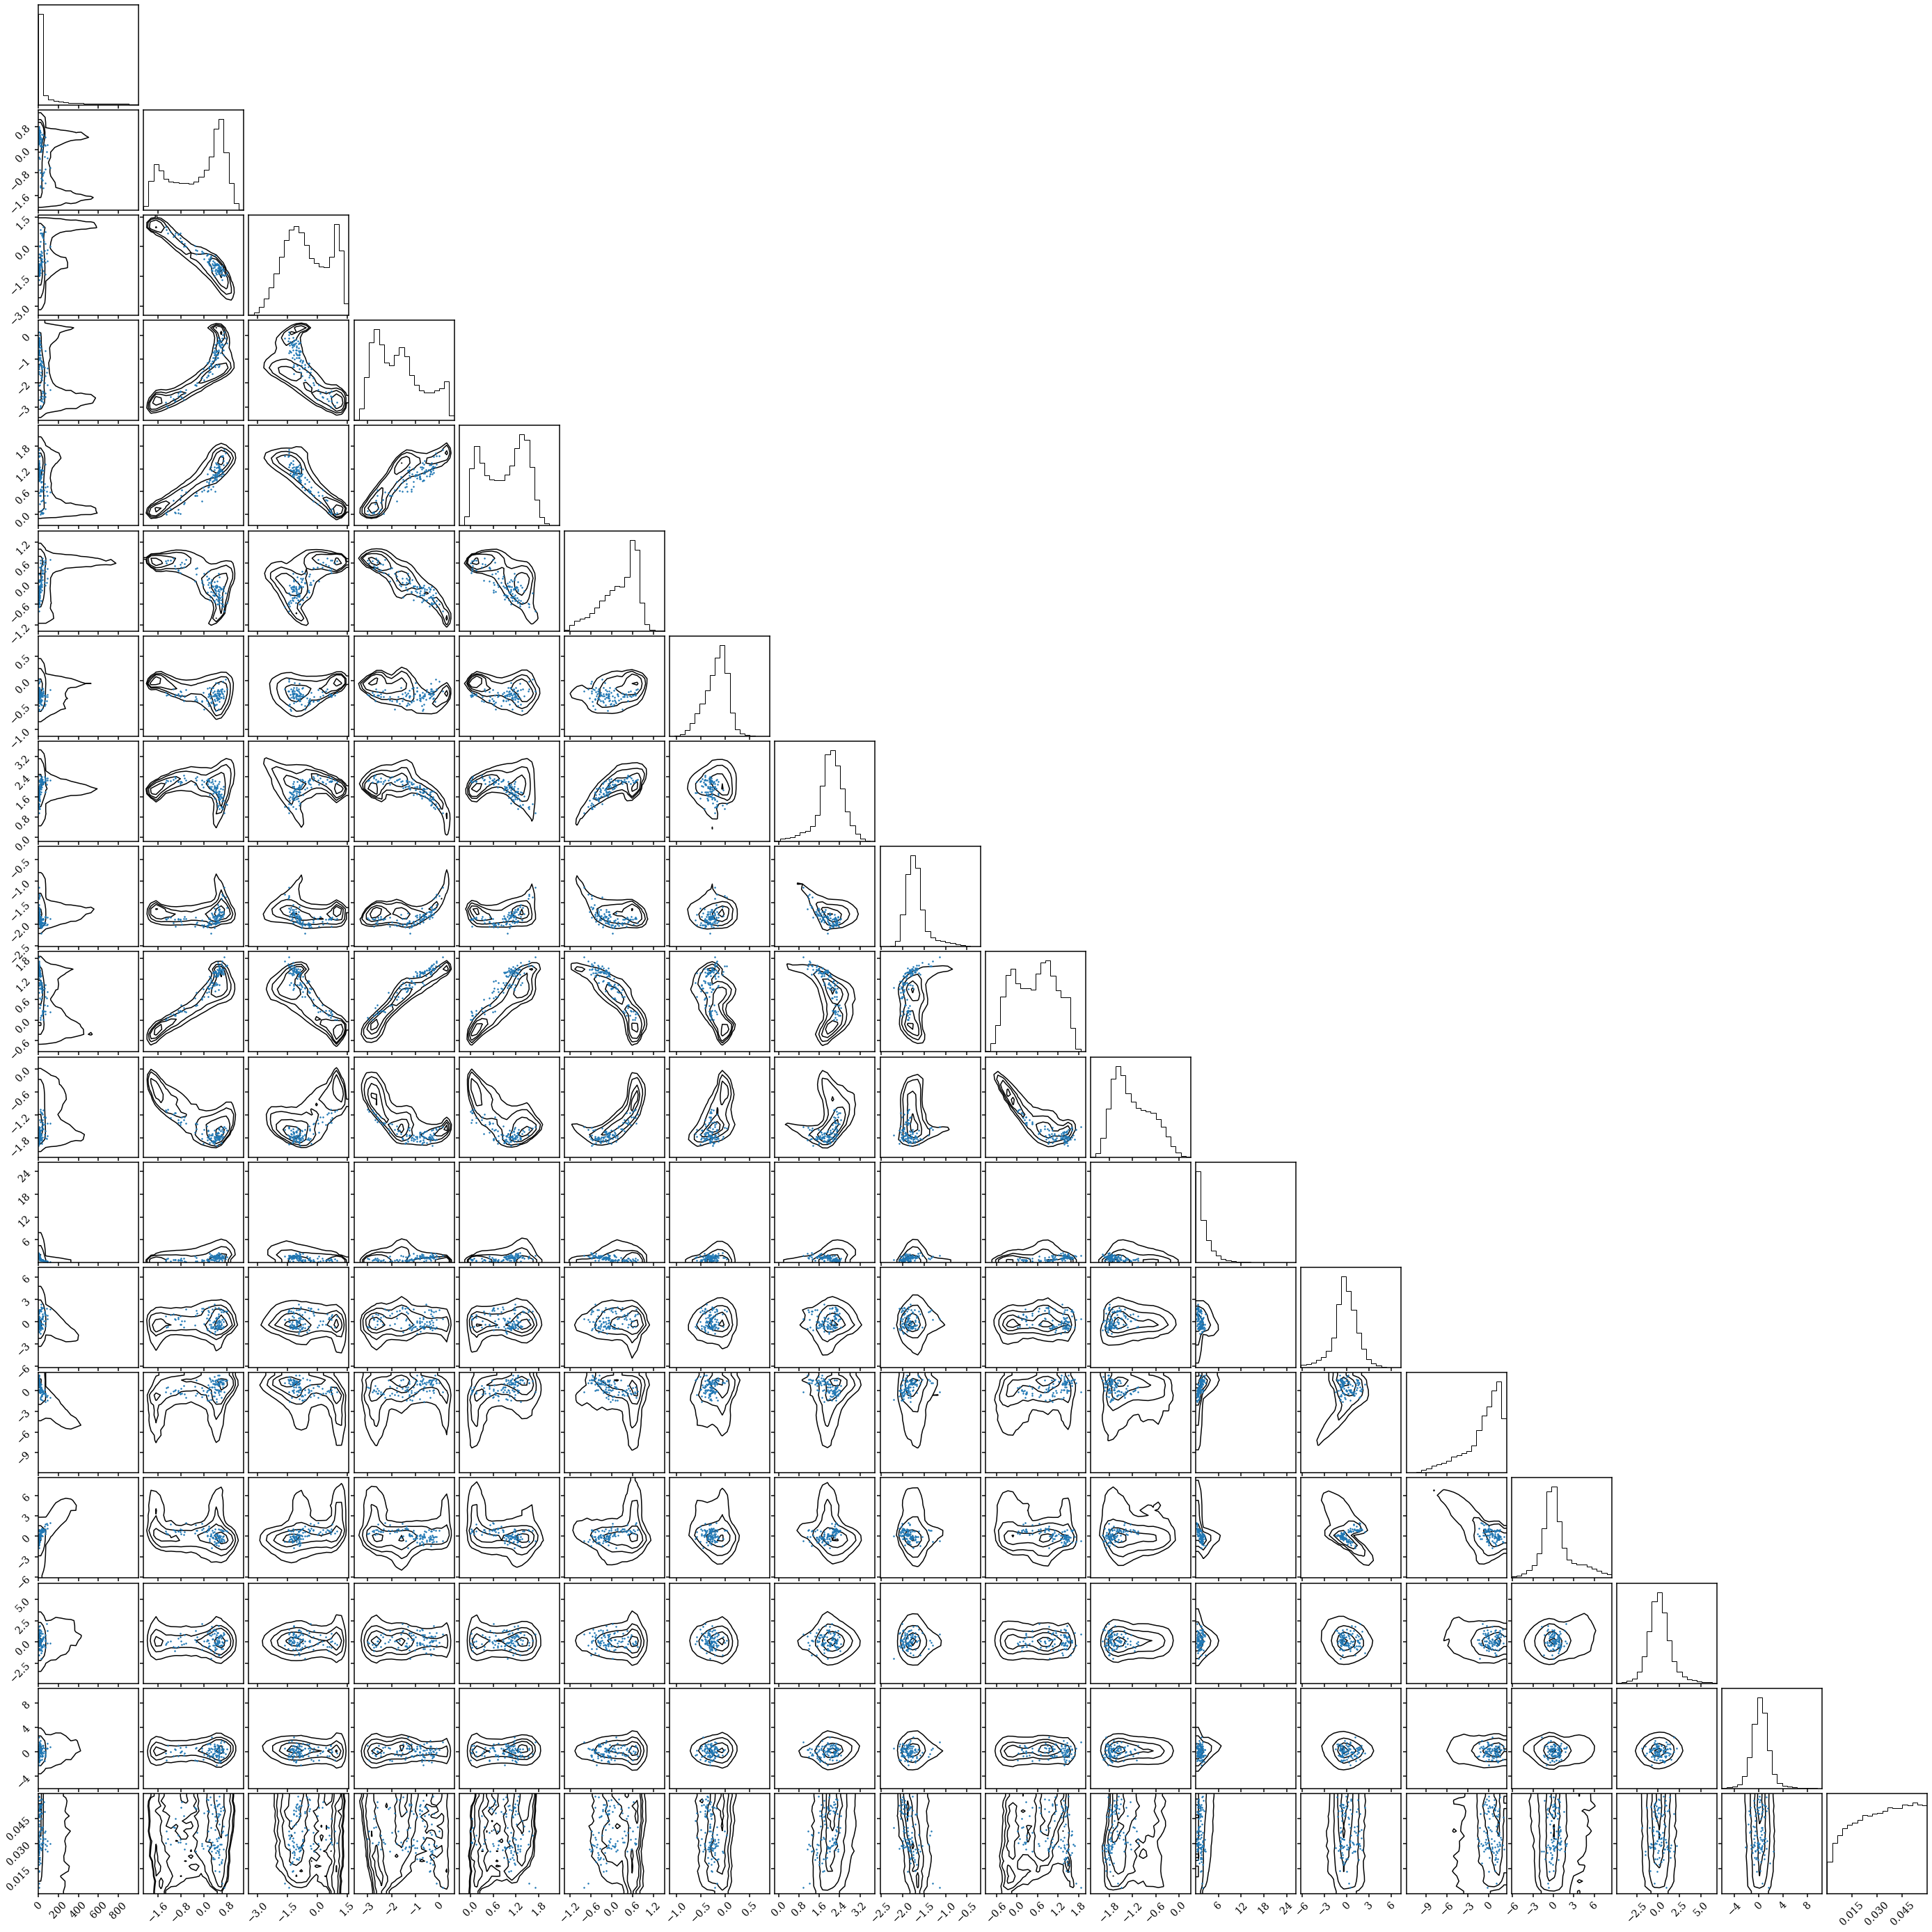

In [25]:
fig = DFM.corner(test_data,
                 hist_kwargs={'density': True},
                 plot_datapoints=False, plot_density=False)
DFM.overplot_points(fig, obs_data[logprob_cut][:100], color='C0', markersize=3)

In [38]:
obs_spec = np.load(os.path.join(dat_dir, 'sdss.clean.spec.npy'))
obs_ivar = np.load(os.path.join(dat_dir, 'sdss.clean.ivar.npy'))
obs_mask = np.load(os.path.join(dat_dir, 'sdss.clean.mask.npy'))
obs_wght = np.load(os.path.join(dat_dir, 'sdss.clean.wght.npy'))

In [40]:
np.save(os.path.join(dat_dir, 'sdss.test.A_spec.npy'), obs_A_spec[logprob_cut])
np.save(os.path.join(dat_dir, 'sdss.test.h_spec.npy'), obs_h_spec[logprob_cut])
np.save(os.path.join(dat_dir, 'sdss.test.A_ivar.npy'), obs_A_ivar[logprob_cut])
np.save(os.path.join(dat_dir, 'sdss.test.h_ivar.npy'), obs_h_ivar[logprob_cut])
np.save(os.path.join(dat_dir, 'sdss.test.zred.npy'), obs_zred[logprob_cut])
np.save(os.path.join(dat_dir, 'sdss.test.spec.npy'), obs_spec[logprob_cut])
np.save(os.path.join(dat_dir, 'sdss.test.ivar.npy'), obs_ivar[logprob_cut])
np.save(os.path.join(dat_dir, 'sdss.test.mask.npy'), obs_mask[logprob_cut])
np.save(os.path.join(dat_dir, 'sdss.test.wght.npy'), obs_wght[logprob_cut])